# LIME - Local Interpretable Model-Agnostic Explanations

Note: This notebook also contains some data analysis and visualization

## Theoretical Explanation

References:
* https://towardsdatascience.com/interpreting-image-classification-model-with-lime-1e7064a2f2e5
* https://darshita1405.medium.com/superpixels-and-slic-6b2d8a6e4f08
* https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/

LIME stands for Local Interpretable Model-agnostic Explanations. It is a Python library based on a paper from [Ribeiro et al.](https://arxiv.org/abs/1602.04938) to help you understand the behavior of your black-box classifier model. Currently, you can use LIME for a classifier model that classify tabular data, images, or texts.

The abbreviation of LIME itself should give you an intuition about the core idea behind it. LIME is:
* **Local**, which means that LIME tries to find the explanation of your black-box model by approximating the local linear behavior of your model.
* **Interpretable**, which means that LIME provides you a solution to understand why your model behaves the way it does.
* **Model agnostic**, which means that LIME is model-independent. In other words, LIME is able to explain any black-box classifier you can think of.

**How it really works?**

Internally, LIME tries to interpret a black box model by conducting these four steps:

1. **Input data permutation:** The first step that LIME would do is to create several artificial data points that are close with the data denoted by the red star.

<img src="https://miro.medium.com/max/4800/1*3yGrd87zJfZ6uWSxDvvbkQ.png" width="400">

If our input data is an image, LIME will generate several samples that are similar with our input image by turning on and off some of the super-pixels of the image (A superpixel can be defined as a group of pixels that share common characteristics like pixel intensity).

<img src="https://miro.medium.com/max/720/1*KNchk6OW9QUxr7okhyV95Q.png" width="400">

2. **Predict the class of each artificial data point:** Next, LIME will predict the class of each of the artificial data point that has been generated using our trained model. If your input data is an image, then the prediction of each perturbed image will be generated at this stage.

3. **Calculate the weight of each artificial data point:** The third step is to calculate the weight of each artificial data to measure its importance. To do this, first the cosine distance metric is usually applied to calculate how far the distance of each artificial data point with respect to our original input data. Next, the distance will be mapped into a value between zero to one with a kernel function. The closer the distance, the closer the mapped value to one, and hence, the bigger the weight. The bigger the weight, the bigger the importance of a certain artificial data point. 
If the input data is an image, then the cosine distance between each perturbed image and the original image will be computed. The more the similarity between a perturbed image to the original image, the bigger its weight and importance.

4. **fit a linear classifier to explain the most important features:** The last step is fitting a linear regression model using the weighted artificial data points. After this step, we should get the fitted coefficient of each feature, just like the usual linear regression analysis. Now if we sort the coefficient, the features that have larger coefficients are the ones that play a big role in determining the prediction of our black-box machine learning model.

**Pratical Example**

Imagine we want to explain a classifier that predicts how likely it is for the image to contain a tree frog. We take the image on the left and divide it into interpretable components (contiguous superpixels).

<img src="https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure3-2cea505fe733a4713eeff3b90f696507.jpg" width="400">

we then generate a data set of perturbed instances by turning some of the interpretable components “off” (in this case, making them gray). For each perturbed instance, we get the probability that a tree frog is in the image according to the model. We then learn a simple (linear) model on this data set, which is locally weighted—that is, we care more about making mistakes in perturbed instances that are more similar to the original image. In the end, we present the superpixels with highest positive weights as an explanation, graying out everything else.

<img src="https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure4-99d9ea184dd35876e0dbae81f6fce038.jpg" width="600">



## Tensorflow General configs and imports

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd 
import numpy as np
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Imports

In [2]:
!pip install -U keras-efficientnet-v2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 67.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 69.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
ERROR: pip's dependency resolver does not currently take into accoun

In [3]:
!pip install lime

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras_efficientnet_v2
import pandas as pd
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random


## Data pre-processing

In [7]:
# Obtain and prepare dataset
import pathlib

data_dir = pathlib.Path('../input/monkeypoxdataset/MonkeypoxSkinDataset')

# Input size Final
batch_size = 32
IMG_SIZE = (124,124)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

Found 42350 files belonging to 6 classes.
Using 33880 files for training.
Found 42350 files belonging to 6 classes.
Using 8470 files for validation.


In [8]:
train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

#test dataset
val_batches = val_ds.cardinality().numpy()
test_ds = val_ds.take(val_batches // 3) 
val_ds = val_ds.skip(val_batches // 3)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Data exploration and visualization

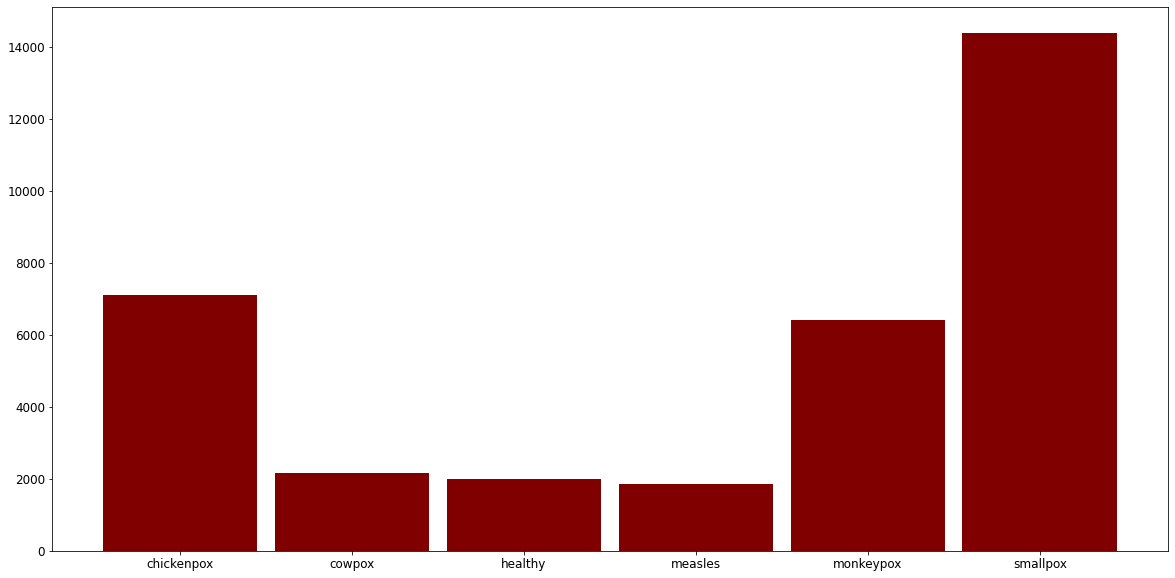

In [9]:
#Class distribution plot

num_classes = 6

count = np.zeros(num_classes, dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()

# creating the bar plot
plt.figure(figsize=(20, 10))
plt.bar(class_names, count, color ='maroon',
        width = 0.9)
plt.show()

In [10]:
# Some info about dataset

#Cardinality 
print('Train Cardinality', train_ds.cardinality().numpy())
print('Validation Cardinality: ', val_ds.cardinality().numpy())
print('Test Cardinality: ', test_ds.cardinality().numpy())

print('Classes: ', class_names)

Train Cardinality 1059
Validation Cardinality:  177
Test Cardinality:  88
Classes:  ['chickenpox', 'cowpox', 'healthy', 'measles', 'monkeypox', 'smallpox']


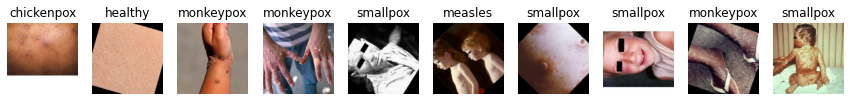

In [11]:
# Visualizar algumas imagens do Dataset
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].numpy().astype("float32")) #pode ser transformado num array numpy 
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Classification using efficientnetV2 - transfer learning

In [12]:
# Loading efficientnetV2 model trained on imagenet dataset
# num_classes=0 means that we do not want the classification top network to be included
# We will put our own classification layers with the number of classes that we have on our data

model = keras_efficientnet_v2.EfficientNetV2S(num_classes=0, input_shape=(124,124,3), pretrained='imagenet')

87859200/87846816 [==============================] - 2s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-imagenet.h5


In [13]:
# Create final model
# The global average pooling layer transforms the information to a linear structure

finalModel = keras.Sequential([
    model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(6, activation='softmax')
])

In [14]:
finalModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EfficientNetV2S (Functional) (None, 4, 4, 1280)        20331360  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 20,339,046
Trainable params: 20,185,174
Non-trainable params: 153,872
_________________________________________________________________


In [15]:
# Load model if already trained
# Ignore warning "Could not open.." - it will work even with that message

finalModel.load_weights('../input/tfmodeltrained/modeltf')

In [16]:
# Even if you load an already trained model in cell above you need to compile it as well

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

finalModel.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [17]:
# Training (will take time if no GPU or TPU is being used - even with GPU/TPU it takes a while)
# Dont run it if you already load the weights

history = finalModel.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
1059/1059 [==============================] - 176s 146ms/step - loss: 5.5559e-05 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9986
Epoch 2/10
1059/1059 [==============================] - 144s 136ms/step - loss: 5.1127e-05 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9986
Epoch 3/10
1059/1059 [==============================] - 147s 139ms/step - loss: 4.6368e-05 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9986
Epoch 4/10
1059/1059 [==============================] - 147s 139ms/step - loss: 4.2192e-05 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9986
Epoch 5/10
1059/1059 [==============================] - 148s 139ms/step - loss: 3.8640e-05 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9986
Epoch 6/10
1059/1059 [==============================] - 147s 139ms/step - loss: 3.5616e-05 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 7/10
1059/1059 [==============================] - 146s 138ms/step - loss: 3.3022e-

In [20]:
#Save the previous trained model

modelSaving = finalModel.save_weights('/kaggle/working/modeltf', save_format='h5')

<AxesSubplot:>

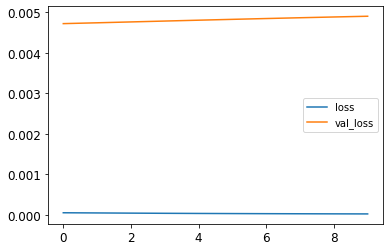

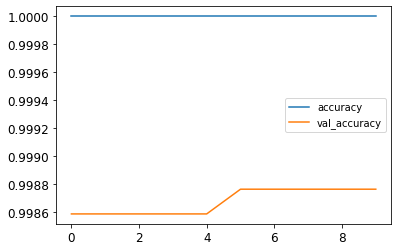

In [21]:
# Results visualization
# Loss and validation loss variation 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [22]:
# Model validation on test sample

score = finalModel.evaluate(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

88/88 [==============================] - 4s 44ms/step - loss: 0.0037 - accuracy: 0.9989
Test loss:  0.003748335177078843
Test accuracy:  0.9989346861839294


## Lime implmentation

In [23]:
#Random select 3 different images

#This is not the best way to random select images but it does the job
for images, labels in train_ds.take(2):
    for i in range(9):
        imageSelected = images[i].numpy().astype("float32")
        imageSelected2 = images[i-1].numpy().astype("float32")
        imageSelected3 = images[i-2].numpy().astype("float32")
        imageLabel = class_names[labels[i]]    
        imageLabel2 = class_names[labels[i-1]]
        imageLabel3 = class_names[labels[i-2]]

### Results on image 1

In [24]:
explainer = lime_image.LimeImageExplainer(random_state=42)

explanation = explainer.explain_instance(
         imageSelected, 
         finalModel.predict
)

# Show all image with the lime border
image, mask = explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)

#Highlight important part of the image
image2, mask2= explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=False, 
         hide_rest=False)

# Show only relevant part of the image
image3, mask3 = explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=True)



  0%|          | 0/1000 [00:00<?, ?it/s]

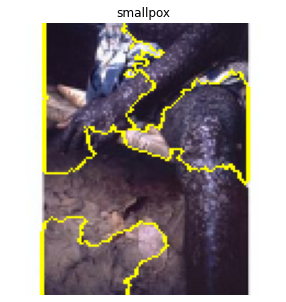

In [25]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected)
plt.title(imageLabel)
plt.axis("off")

plt.imshow(mark_boundaries(image, mask))

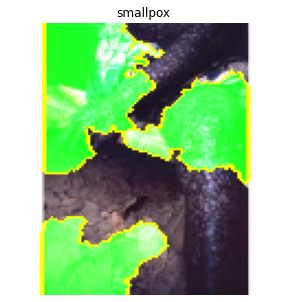

In [26]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected)
plt.title(imageLabel)
plt.axis("off")

plt.imshow(mark_boundaries(image2, mask2))

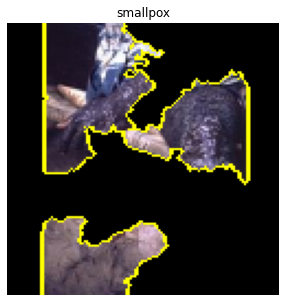

In [27]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected)
plt.title(imageLabel)
plt.axis("off")

plt.imshow(mark_boundaries(image3, mask3))

### Results on image 2

In [28]:
explainer = lime_image.LimeImageExplainer(random_state=42)

explanation = explainer.explain_instance(
         imageSelected2, 
         finalModel.predict
)

# Show all image with the lime border
image, mask = explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected2.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)

#Highlight important part of the image
image2, mask2= explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected2.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=False, 
         hide_rest=False)

# Show only relevant part of the image
image3, mask3 = explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected2.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

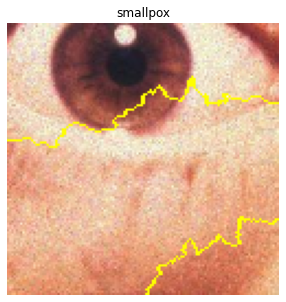

In [29]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected2)
plt.title(imageLabel2)
plt.axis("off")

plt.imshow(mark_boundaries(image, mask))

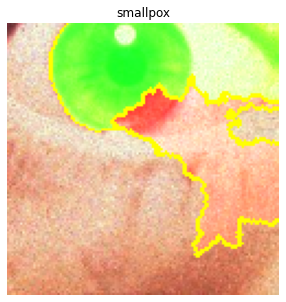

In [30]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected2)
plt.title(imageLabel2)
plt.axis("off")

plt.imshow(mark_boundaries(image2, mask2))

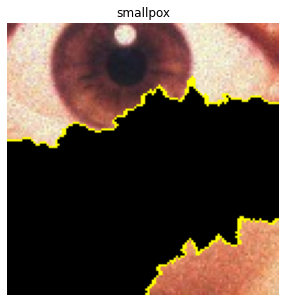

In [31]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected2)
plt.title(imageLabel2)
plt.axis("off")

plt.imshow(mark_boundaries(image3, mask3))

### Results on image 3

In [32]:
explainer = lime_image.LimeImageExplainer(random_state=42)

explanation = explainer.explain_instance(
         imageSelected3, 
         finalModel.predict
)

# Show all image with the lime border
image, mask = explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected3.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)

#Highlight important part of the image
image2, mask2= explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected3.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=False, 
         hide_rest=False)

# Show only relevant part of the image
image3, mask3 = explanation.get_image_and_mask(
         finalModel.predict(
              imageSelected3.reshape((1,124,124,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

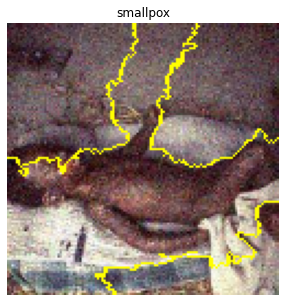

In [33]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected3)
plt.title(imageLabel3)
plt.axis("off")

plt.imshow(mark_boundaries(image, mask))

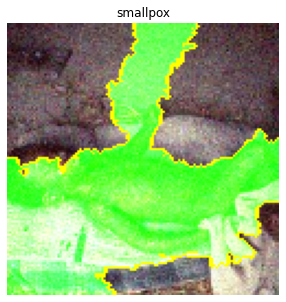

In [34]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected3)
plt.title(imageLabel3)
plt.axis("off")

plt.imshow(mark_boundaries(image2, mask2))

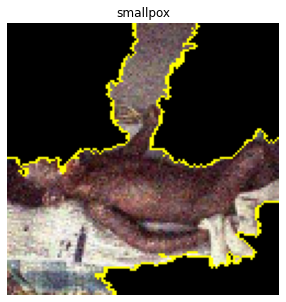

In [35]:
plt.figure(figsize=(5, 5))
plt.imshow(imageSelected3)
plt.title(imageLabel3)
plt.axis("off")

plt.imshow(mark_boundaries(image3, mask3))